In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc, accuracy_score


pd. set_option("display.max_columns", None)
pd. set_option("display.max_rows", None)
import warnings
warnings.filterwarnings('ignore')

In [72]:
# Load data
df_raw = pd.read_csv('credit_card_2015_2016.csv')

In [73]:
df_raw.head()

,term,sub_grade,grade,emp_length,issue_y,revol_util_n,int_rate_n,installment_n,tot_hi_cred_lim_n,dti_n,avg_cur_bal_n,all_util_n,acc_open_past_24mths_n,annual_inc_n,loan_amnt_n,loan_status
0,60 months,C4,C,10+ years,15,87.1,14.31,702.30,350349,36.91,35256,100,1,98000.0,29975,Fully Paid
1,60 months,C1,C,< 1 year,15,57.0,12.29,268.70,43525,18.80,2990,100,2,45000.0,12000,Fully Paid
2,36 months,B3,B,1 year,15,42.8,9.99,258.10,72655,19.34,6569,100,5,62500.0,8000,Fully Paid
3,36 months,A4,A,3 years,15,95.7,7.26,433.95,62695,11.31,9416,100,0,127000.0,14000,Fully Paid
4,36 months,B5,B,< 1 year,15,91.8,11.53,758.78,120674,23.07,7059,100,6,116000.0,23000,Fully Paid


In [74]:
df_raw.info() #emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    40000 non-null  object 
 1   sub_grade               40000 non-null  object 
 2   grade                   40000 non-null  object 
 3   emp_length              37459 non-null  object 
 4   issue_y                 40000 non-null  int64  
 5   revol_util_n            40000 non-null  float64
 6   int_rate_n              40000 non-null  float64
 7   installment_n           40000 non-null  float64
 8   tot_hi_cred_lim_n       40000 non-null  int64  
 9   dti_n                   40000 non-null  float64
 10  avg_cur_bal_n           40000 non-null  int64  
 11  all_util_n              40000 non-null  int64  
 12  acc_open_past_24mths_n  40000 non-null  int64  
 13  annual_inc_n            40000 non-null  float64
 14  loan_amnt_n             40000 non-null

In [75]:
# Separate training and OOT data
df_train = df_raw[df_raw['issue_y'] == 15].copy()
df_oot = df_raw[df_raw['issue_y'] == 16].copy()

print(df_train.shape, df_oot.shape)

(20000, 16) (20000, 16)


In [76]:
df_train.info() # emp_length has missing values

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   term                    20000 non-null  object 
 1   sub_grade               20000 non-null  object 
 2   grade                   20000 non-null  object 
 3   emp_length              18747 non-null  object 
 4   issue_y                 20000 non-null  int64  
 5   revol_util_n            20000 non-null  float64
 6   int_rate_n              20000 non-null  float64
 7   installment_n           20000 non-null  float64
 8   tot_hi_cred_lim_n       20000 non-null  int64  
 9   dti_n                   20000 non-null  float64
 10  avg_cur_bal_n           20000 non-null  int64  
 11  all_util_n              20000 non-null  int64  
 12  acc_open_past_24mths_n  20000 non-null  int64  
 13  annual_inc_n            20000 non-null  float64
 14  loan_amnt_n             20000 non-null  int

Create the dichotomous output variable 'Outcome' by combining Charge off (which is actual loss) with Late (31-120 days) which is likely to be a loss

In [77]:
# Create Outcome variable (simply put, 1 means bad  or risky loan, 0 means good loan)
df_train['Outcome'] = df_train['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)'] else 0)
print(df_train['Outcome'].value_counts())
print(df_train['Outcome'].value_counts(normalize=True))

Outcome
0    16401
1     3599
Name: count, dtype: int64
Outcome
0    0.82005
1    0.17995
Name: proportion, dtype: float64


In [78]:
# Basic information of categorical data
print("Counts of categorical features:\n", df_train.describe(include=['object', 'category']))
print('************Loan Status Counts******************')
print(df_train.value_counts(['loan_status']))
print(df_train['loan_status'].value_counts(normalize=True))
print('************Term Counts******************')
print(df_train.value_counts(['term']))
print(df_train['term'].value_counts(normalize=True))
print('*********Grade Counts*************')
print(df_train.value_counts(['grade']))
print(df_train['grade'].value_counts(normalize=True))
print('*********Sub Grade Counts*************')
print(df_train.value_counts(['sub_grade']))
print(df_train['sub_grade'].value_counts(normalize=True))

Counts of categorical features:
              term sub_grade  grade emp_length loan_status
count       20000     20000  20000      18747       20000
unique          2        34      7         11           3
top     36 months        A5      B  10+ years  Fully Paid
freq        15696      1606   6805       6099       16401
************Loan Status Counts******************
loan_status       
Fully Paid            16401
Charged Off            3413
Late (31-120 days)      186
Name: count, dtype: int64
loan_status
Fully Paid            0.82005
Charged Off           0.17065
Late (31-120 days)    0.00930
Name: proportion, dtype: float64
************Term Counts******************
term     
36 months    15696
60 months     4304
Name: count, dtype: int64
term
36 months    0.7848
60 months    0.2152
Name: proportion, dtype: float64
*********Grade Counts*************
grade
B        6805
A        5902
C        4760
D        1645
E         734
F         137
G          17
Name: count, dtype: int64
grade

As a part of feature engineering in experiment-3, create broader bins for emp_length (0 for 0-2 years, 1 for 3-5 years, 2 for 6-8 years and 3 for 9 and above)

In [79]:
# Map emp_length to ordinal numbers as per the feature definition ( Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years)
emp_length_map = {'< 1 year': 'le2', '1 year': 'le2', '2 years': 'le2', '3 years': '3to5', '4 years': '3to5',
                  '5 years': '3to5', '6 years': '6to8', '7 years': '6to8', '8 years': '6to8', '9 years': '9+', '10+ years': '9+'}

df_train['emp_length'] = df_train['emp_length'].map(emp_length_map)

# Check missing values
print(df_train['emp_length'].isnull().sum())

1253


In [80]:
print("\nBasic Statistics of Numerical features:\n", df_train.describe().round(2))


Basic Statistics of Numerical features:
        issue_y  revol_util_n  int_rate_n  installment_n  tot_hi_cred_lim_n  \
count  20000.0      20000.00    20000.00       20000.00           20000.00   
mean      15.0         56.52       10.79         451.95          173900.06   
std        0.0         22.25        3.75         246.46          177436.45   
min       15.0         -1.00        5.32          30.12            2700.00   
25%       15.0         39.90        7.89         267.21           50600.00   
50%       15.0         56.50        9.99         392.81          108749.00   
75%       15.0         73.53       12.99         602.30          249877.75   
max       15.0        124.70       27.88        1306.90         3754640.00   

          dti_n  avg_cur_bal_n  all_util_n  acc_open_past_24mths_n  \
count  20000.00       20000.00    20000.00                20000.00   
mean      18.93       12949.71       98.50                    4.43   
std        8.47       15657.95        8.37   

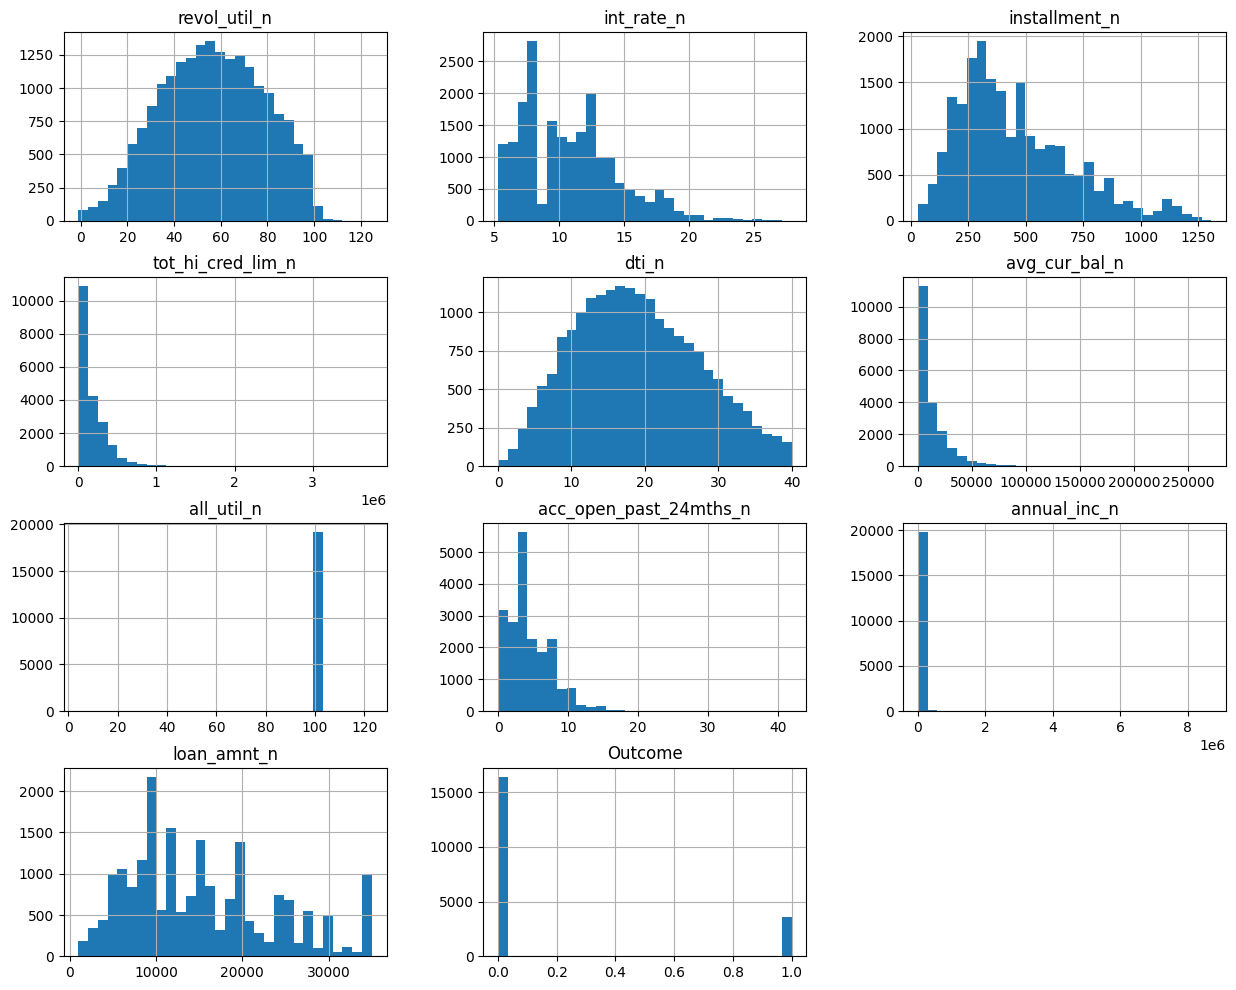

In [81]:
# Distribution plots for numerical features (excluding issue year)
num_cols = [col for col in df_train.select_dtypes(include='number').columns if col != 'issue_y']
df_train[num_cols].hist(figsize=(15, 12), bins=30)
plt.show()

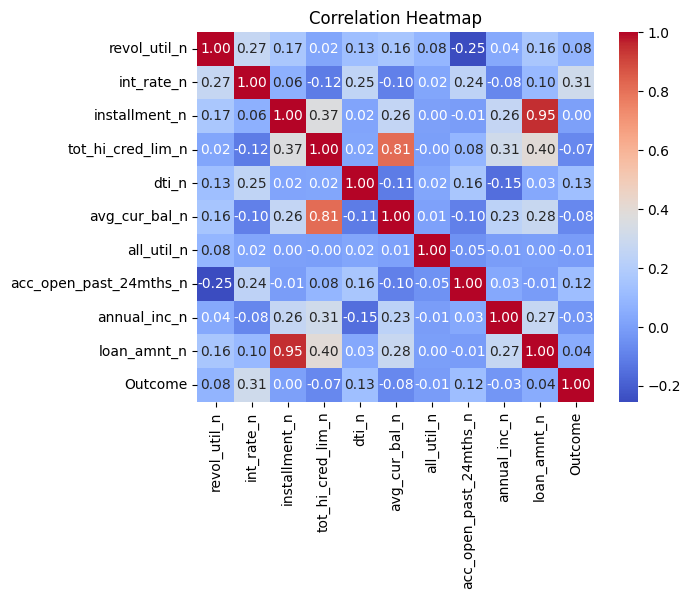

In [82]:
# Correlation map
# plt.figure(figsize=(12, 10))
sns.heatmap(df_train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In all_util_n as >19k out of 20k records has value 100, create 2 bins : <100 and 100+

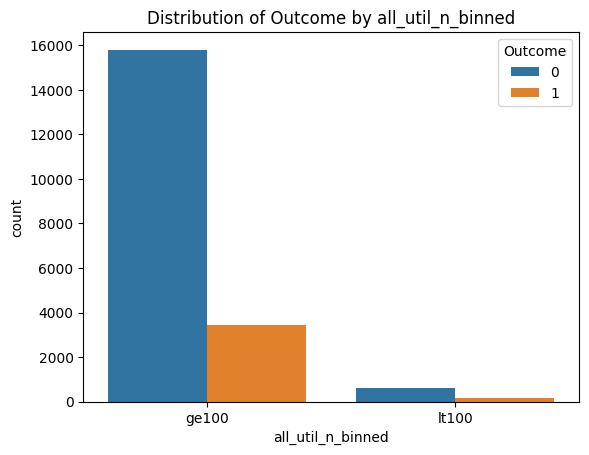

In [83]:
df_train['all_util_n_binned'] = np.where(df_train['all_util_n'] < 100, 'lt100', 'ge100')

sns.countplot(data=df_train, x='all_util_n_binned', hue='Outcome')
plt.title('Distribution of Outcome by all_util_n_binned')
plt.show()

As a part of data engineering in experimemt 2, perform the following:
1) Drop installment_n due to very high correlation with loan_amnt_n
2) tot_hi_cred_lim_avg_cur_bal_n = tot_hi_cred_lim_n/avg_cur_bal_n (highly correlated)
3) In all_util_n as >19k out of 20k records has value 100, we have created 2 bins. Now drop the original column
4) log transformation of annual_inc_n as it is highly skewed
5) Frop grade due to Cramer's values of 1 with sub_grade

In [ ]:
# 1. Drop installment_n due to very high correlation with loan_Mant_n
df_train = df_train.drop(columns=['installment_n'])

# 2. Create tot_hi_cred_lim_avg_cur_bal_n = tot_hi_cred_lim_n / avg_cur_bal_n and do log transformation
df_train['tot_hi_cred_lim_avg_cur_bal_n'] = df_train['avg_cur_bal_n']/ df_train['tot_hi_cred_lim_n']
df_train = df_train.drop(columns=['tot_hi_cred_lim_n','avg_cur_bal_n'])
df_train['tot_hi_cred_lim_avg_cur_bal_log_n'] = np.log1p(df_train['tot_hi_cred_lim_avg_cur_bal_n'])
df_train = df_train.drop(columns=['tot_hi_cred_lim_avg_cur_bal_n'])

# 3. Drop all_util_n as we have created bins for this feature   
df_train = df_train.drop(columns=['all_util_n'])

# 4. Log transformation of annual_income
df_train['annual_inc_log_n'] = np.log1p(df_train['annual_inc_n'])
df_train = df_train.drop(columns=['annual_inc_n'])

# 5. Drop grade as it is correlated to sub_grade
df_train = df_train.drop(columns=['grade'])

In [85]:
df_train.head()

,term,sub_grade,emp_length,issue_y,revol_util_n,int_rate_n,dti_n,acc_open_past_24mths_n,loan_amnt_n,loan_status,Outcome,all_util_n_binned,tot_hi_cred_lim_avg_cur_bal_log_n,annual_inc_log_n
0,60 months,C4,9+,15,87.1,14.31,36.91,1,29975,Fully Paid,0,ge100,0.095884,11.492733
1,60 months,C1,le2,15,57.0,12.29,18.80,2,12000,Fully Paid,0,ge100,0.066439,10.714440
2,36 months,B3,le2,15,42.8,9.99,19.34,5,8000,Fully Paid,0,ge100,0.086557,11.042938
3,36 months,A4,3to5,15,95.7,7.26,11.31,0,14000,Fully Paid,0,ge100,0.139925,11.751950
4,36 months,B5,le2,15,91.8,11.53,23.07,6,23000,Fully Paid,0,ge100,0.056849,11.661354


In [86]:
#update num_cols
num_cols = [col for col in df_train.columns if col.endswith('_n')]
print(num_cols)

['revol_util_n', 'int_rate_n', 'dti_n', 'acc_open_past_24mths_n', 'loan_amnt_n', 'tot_hi_cred_lim_avg_cur_bal_log_n', 'annual_inc_log_n']


Plot the numerical features against the Outcome variable

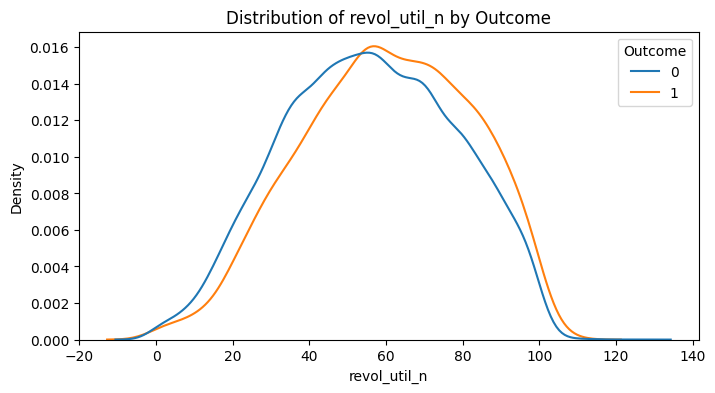

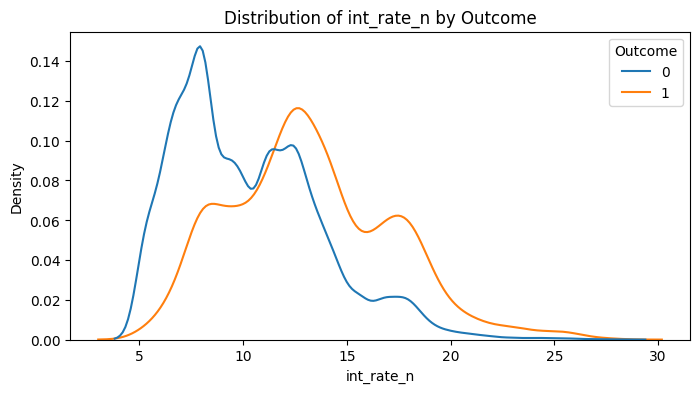

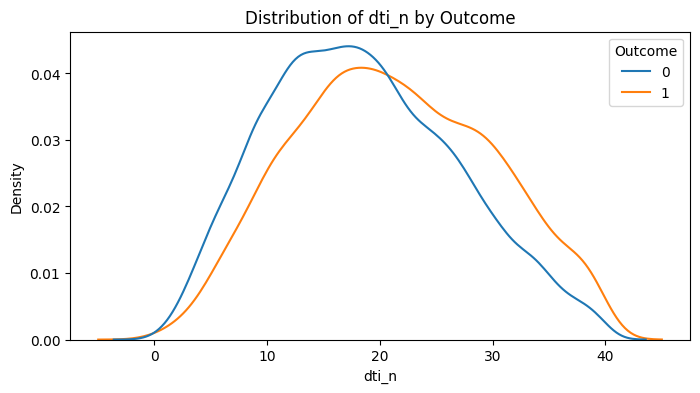

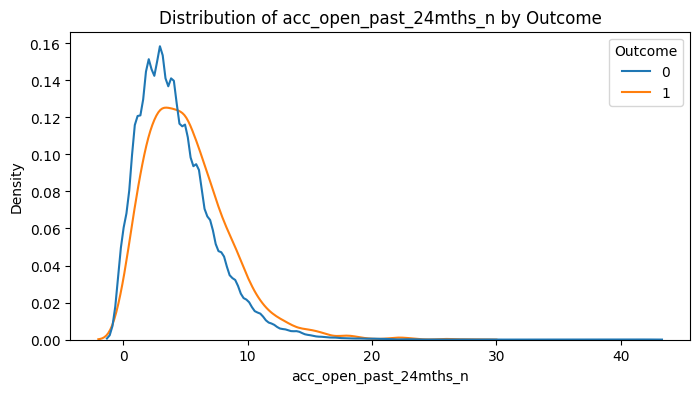

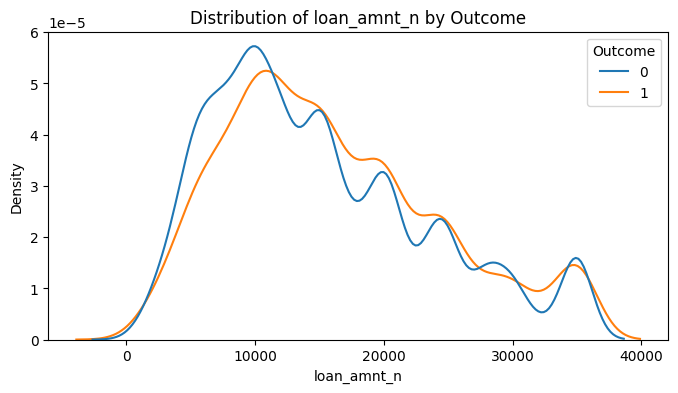

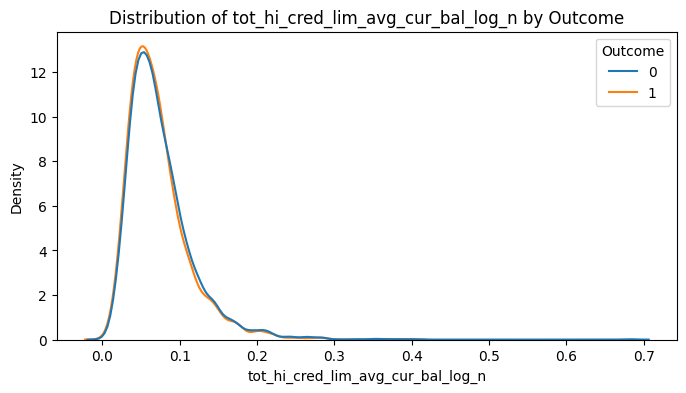

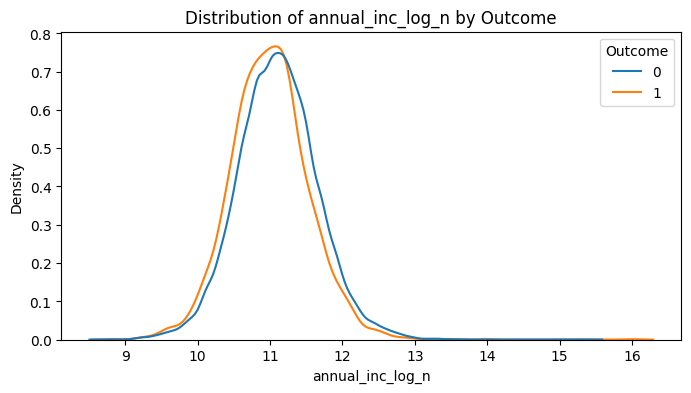

In [87]:
for feature in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df_train, x=feature, hue='Outcome', common_norm=False) #Common_norm false means each group’s density curve is normalized independently
    plt.title(f'Distribution of {feature} by Outcome')
    plt.show()

Boxplot and outlier check: xgboost is generally robust to outliers, but it may impact the generalizability of the model

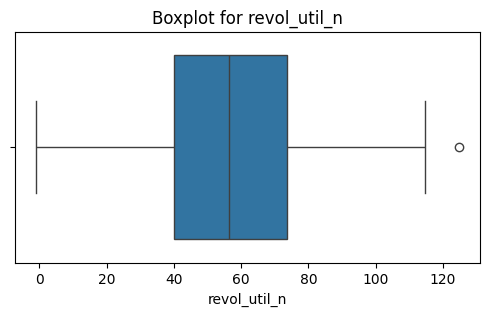

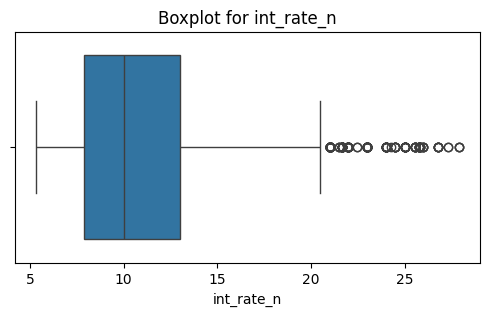

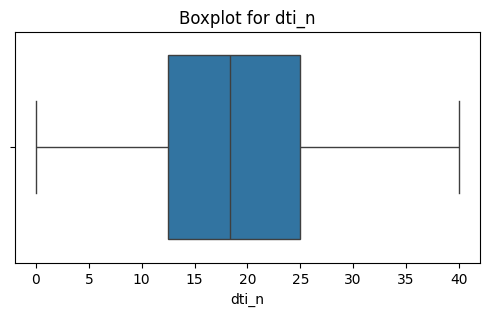

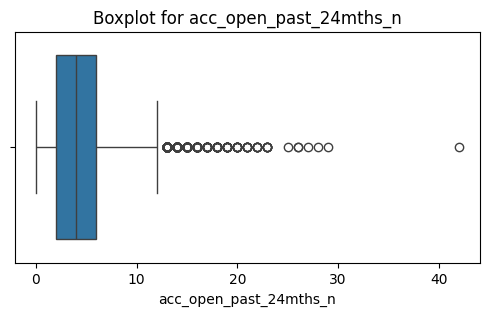

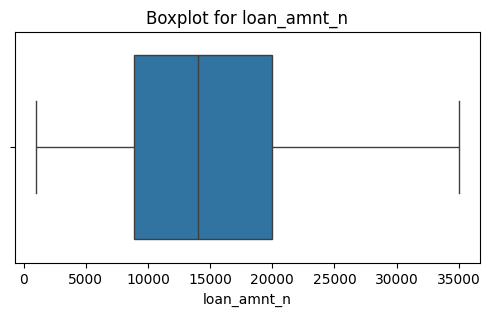

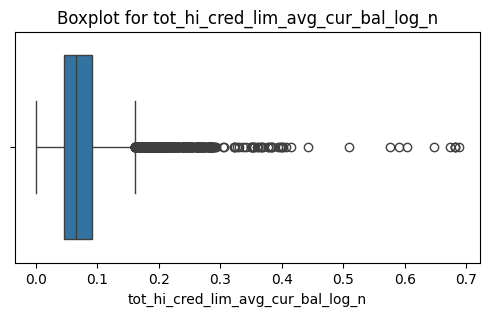

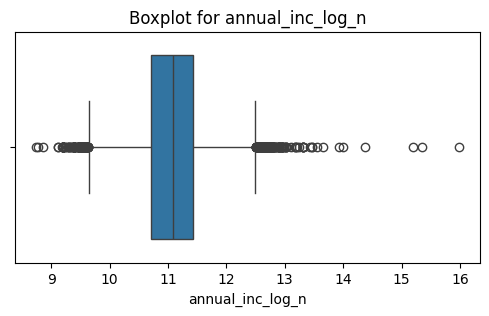

revol_util_n                           1
int_rate_n                           251
dti_n                                  0
acc_open_past_24mths_n               397
loan_amnt_n                            0
tot_hi_cred_lim_avg_cur_bal_log_n    850
annual_inc_log_n                     322
dtype: int64


In [88]:
# Check for outliers
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_train[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Outlier detection using IQR
Q1 = df_train[num_cols].quantile(0.25)
Q3 = df_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_train[num_cols] < (Q1 - 1.5 * IQR)) | (df_train[num_cols] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

Run t-test and Manwhitneyu to check if there is statistically significant difference between the means of a numerical variables for good and bad loans

Unlike the t-test, which compares means and assumes that the data are normally distributed and have equal variances, Mann-WhitneyU test does not require the data to be normally distributed and is suitable for data when the assumptions of the t-test are not met

In [89]:
results = []

for col in num_cols:
    group0 = df_train[df_train['Outcome'] == 0][col].dropna()
    group1 = df_train[df_train['Outcome'] == 1][col].dropna()
    
    # t-test
    t_stat, t_p = ttest_ind(group0, group1, equal_var=False)
    # Mann-Whitney U test
    u_stat, u_p = mannwhitneyu(group0, group1, alternative='two-sided')
    
    # Significance check (alpha = 0.05)
    t_significant = 'Significant' if t_p < 0.05 else 'Not Significant'
    u_significant = 'Significant' if u_p < 0.05 else 'Not Significant'
    
    results.append({
        'feature': col,
        't-test p-value': t_p,
        't-test significance': t_significant,
        'Mann-Whitney p-value': u_p,
        'Mann-Whitney significance': u_significant
    })

summary_df = pd.DataFrame(results)
print(summary_df)


                             feature  t-test p-value t-test significance  \
0                       revol_util_n    1.036634e-27         Significant   
1                         int_rate_n    0.000000e+00         Significant   
2                              dti_n    9.970022e-66         Significant   
3             acc_open_past_24mths_n    1.963690e-56         Significant   
4                        loan_amnt_n    2.141723e-10         Significant   
5  tot_hi_cred_lim_avg_cur_bal_log_n    4.725824e-05         Significant   
6                   annual_inc_log_n    9.383280e-30         Significant   

   Mann-Whitney p-value Mann-Whitney significance  
0          3.581338e-27               Significant  
1          0.000000e+00               Significant  
2          2.424016e-65               Significant  
3          1.675858e-64               Significant  
4          2.517906e-13               Significant  
5          3.853879e-04               Significant  
6          3.188651e-31    

In [90]:
# from scipy.stats import f_oneway
# import pandas as pd

# anova_results = []

# for col in num_cols:
#     # Extract the values for each Outcome group
#     groups = [df_train[df_train['Outcome'] == outcome][col].dropna() for outcome in df_train['Outcome'].unique()]
    
#     # Perform ANOVA if there are at least 2 groups with data
#     if len(groups) >= 2 and all(len(g) > 0 for g in groups):
#         f_stat, p_val = f_oneway(*groups)
#         anova_results.append({'Variable': col, 'F-statistic': f_stat, 'p-value': p_val})
#     else:
#         anova_results.append({'Variable': col, 'F-statistic': None, 'p-value': None})
    
# # Display results as a DataFrame
# anova_df = pd.DataFrame(anova_results)
# anova_df['Significant'] = np.where(anova_df['p-value'] < 0.05, 'Yes', 'No')
# print(anova_df)


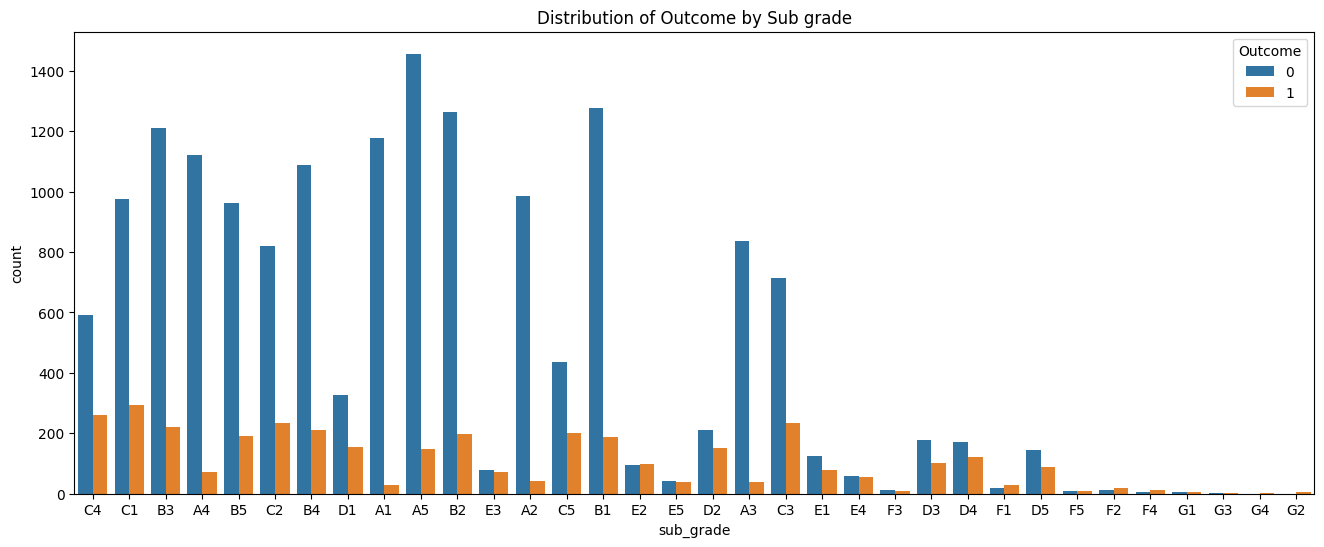

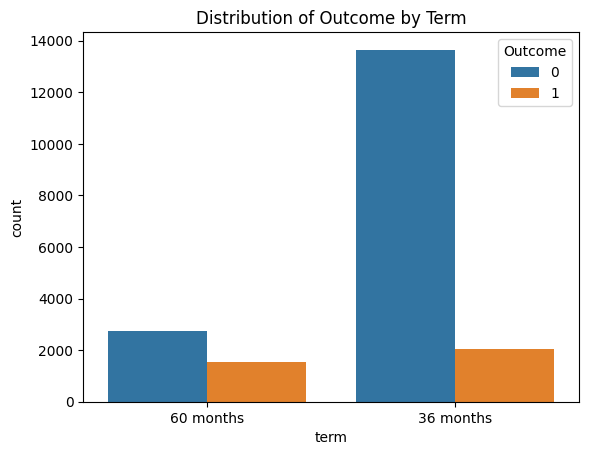

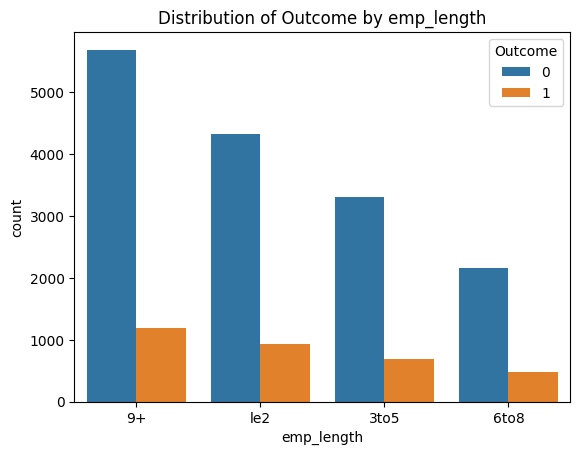

In [91]:
#Plot categorical variables with Outcome variable

# sns.countplot(data=df_train, x='grade', hue='Outcome')
# plt.title('Distribution of Outcome by grade')
# plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(data=df_train, x='sub_grade', hue='Outcome')
plt.title('Distribution of Outcome by Sub grade')
plt.show()

sns.countplot(data=df_train, x='term', hue='Outcome')
plt.title('Distribution of Outcome by Term')
plt.show()

sns.countplot(data=df_train, x='emp_length', hue='Outcome')
plt.title('Distribution of Outcome by emp_length')
plt.show()

Missing value in emp_lenght treated with KNN classifier

In [92]:
# Step 1: Separate known and missing
mask_missing = df_train['emp_length'].isnull()
df_known = df_train[~mask_missing]
df_missing = df_train[mask_missing]

# Step 2: Encode emp_length and other categorical fearures
le = LabelEncoder()

df_missing['sub_grade'] = le.fit_transform(df_missing['sub_grade'])
df_missing['term'] = le.fit_transform(df_missing['term'])
df_missing['all_util_n_binned'] = le.fit_transform(df_missing['all_util_n_binned'])


df_known['sub_grade'] = le.fit_transform(df_known['sub_grade'])
df_known['term'] = le.fit_transform(df_known['term'])
df_known['all_util_n_binned'] = le.fit_transform(df_known['all_util_n_binned'])
df_known['emp_length_enc'] = le.fit_transform(df_known['emp_length'])


# Step 3: Select features for prediction (exclude emp_length itself)
feature_cols = [col for col in df_train.columns if col not in ['emp_length','loan_status','issue_y']]  

X_train = df_known[feature_cols]
y_train = df_known['emp_length_enc']
X_missing = df_missing[feature_cols]

# Step 4: Fit KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 5: Predict missing emp_length
preds = knn.predict(X_missing)
preds_labels = le.inverse_transform(preds)

# Step 6: Fill the missing values
df_train.loc[mask_missing, 'emp_length'] = preds_labels


In [93]:
df_train['emp_length'].value_counts()

emp_length
9+      7371
le2     5512
3to5    4336
6to8    2781
Name: count, dtype: int64

Run the chi-square test to determine whether there is a significant relationship between the categorical variables and Outcome

In [94]:
# cat_cols = ['term', 'sub_grade','emp_length'] #'grade'
# target = 'Outcome'

# def chi_square_test(data, predictor, target):
#     contingency_table = pd.crosstab(data[predictor], data[target])
#     chi2, p, dof, expected = chi2_contingency(contingency_table)
#     return chi2, p

# # Store results
# results = []

# for col in cat_cols:
#     chi2, p = chi_square_test(df_train, col, target)
#     significance = 'Significant' if p < 0.05 else 'Not Significant'
#     results.append({'feature': col, 'chi2_stat': chi2, 'p_value': p, 'significance': significance})

# # Display as DataFrame
# results_df = pd.DataFrame(results)
# print(results_df)


Since sub_grade is at more granular level of grade, there is a possibility they are closely associated. We can check with Cramer's V which measures the strength of association between two categorical variables 

In [95]:
# contingency = pd.crosstab(df_train['grade'], df_train['sub_grade'])
# chi2, p, dof, expected = chi2_contingency(contingency)
# # Calculate Cramer’s V
# n = contingency.sum().sum()
# cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))
# print(cramers_v)

In [96]:
df_train_coded=df_train.copy()
# Encode categorical variables
le = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False, drop='first')

#label encoding for sub_category
df_train_coded['sub_grade'] = le.fit_transform(df_train_coded['sub_grade'])
# df_train_coded['grade'] = le.fit_transform(df_train_coded['grade'])

#one hot encoding for other categorical columns
encoded = ohe.fit_transform(df_train_coded[['term', 'emp_length','all_util_n_binned']])


# Create DataFrame with new one-hot encoded columns
encoded_df = pd.DataFrame(
    encoded, 
    columns=ohe.get_feature_names_out(['term', 'emp_length','all_util_n_binned']),
    index=df_train_coded.index
)

# Concatenate the encoded columns with the original DataFrame (drop originals)
df_train_coded = pd.concat([
    df_train_coded.drop(columns=['term', 'emp_length','all_util_n_binned']),
    encoded_df
], axis=1)

In [97]:
df_train_coded.head()

,sub_grade,issue_y,revol_util_n,int_rate_n,dti_n,acc_open_past_24mths_n,loan_amnt_n,loan_status,Outcome,tot_hi_cred_lim_avg_cur_bal_log_n,annual_inc_log_n,term_60 months,emp_length_6to8,emp_length_9+,emp_length_le2,all_util_n_binned_lt100
0,13,15,87.1,14.31,36.91,1,29975,Fully Paid,0,0.095884,11.492733,1.0,0.0,1.0,0.0,0.0
1,10,15,57.0,12.29,18.80,2,12000,Fully Paid,0,0.066439,10.714440,1.0,0.0,0.0,1.0,0.0
2,7,15,42.8,9.99,19.34,5,8000,Fully Paid,0,0.086557,11.042938,0.0,0.0,0.0,1.0,0.0
3,3,15,95.7,7.26,11.31,0,14000,Fully Paid,0,0.139925,11.751950,0.0,0.0,0.0,0.0,0.0
4,9,15,91.8,11.53,23.07,6,23000,Fully Paid,0,0.056849,11.661354,0.0,0.0,0.0,1.0,0.0


Build the xgboost models using 5-fold cross-validation, repeated 3 times using different random seeds

In [99]:
X = df_train_coded.drop(['loan_status', 'Outcome', 'issue_y'], axis=1)
y = df_train_coded['Outcome']

def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# gini_scorer = make_scorer(gini_score, needs_proba=True)

results = []

# Define your random seeds for the 3 repetitions
seeds = [92, 123, 999]

for seed in seeds:
    # StratifiedKFold for class balance in each fold
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)
    for fold, (train_i, val_i) in enumerate(kf.split(X, y), 1):
        X_train, X_val = X.iloc[train_i], X.iloc[val_i]
        y_train, y_val = y.iloc[train_i], y.iloc[val_i]
        
        # Train XGBoost model
        model = XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=seed)
        model.fit(X_train, y_train)
        
        # Predict probabilities and classes
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)
        gini = gini_score(y_val, y_pred_proba)
        
        # Store results
        results.append({
            'Seed': seed,
            'Fold': fold,
            'Accuracy': round(accuracy, 3),
            'AUC-ROC': round(auc, 3),
            'Gini': round(gini, 3)
        })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

# Print all results
print("Cross-Validation Results (15 Models):")
print(results_df)

# Print average metrics across all runs
print("\nAverage Metrics Across All Runs:")
print(results_df[['Accuracy', 'AUC-ROC', 'Gini']].mean().round(3))
print("\nStandard deviation of Gini:")
print(results_df[['Gini']].std().round(3))


Cross-Validation Results (15 Models):
    Seed  Fold  Accuracy  AUC-ROC   Gini
0     92     1     0.808    0.708  0.416
1     92     2     0.814    0.697  0.395
2     92     3     0.819    0.698  0.396
3     92     4     0.816    0.706  0.413
4     92     5     0.809    0.696  0.391
5    123     1     0.802    0.695  0.389
6    123     2     0.821    0.708  0.415
7    123     3     0.816    0.708  0.415
8    123     4     0.815    0.693  0.386
9    123     5     0.810    0.700  0.400
10   999     1     0.817    0.691  0.382
11   999     2     0.807    0.695  0.389
12   999     3     0.816    0.709  0.419
13   999     4     0.810    0.690  0.379
14   999     5     0.811    0.708  0.416

Average Metrics Across All Runs:
Accuracy    0.813
AUC-ROC     0.700
Gini        0.400
dtype: float64

Standard deviation of Gini:
Gini    0.014
dtype: float64


Hyper-parameter tuning

In [100]:
# Define hyperparameter grid 
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

In [ ]:
gini_scorer = make_scorer(gini_score, needs_proba=True)

# XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=11)

# RepeatedStratifiedKFold CV with 5 splits and repeated 3 times
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,   # Number of random combinations to try
    scoring=gini_scorer,
    n_jobs=-1,   # Use all cores
    cv=cv,
    verbose=2,
    random_state=11,
    return_train_score=True
)

# Fit the search
random_search.fit(X, y)

# Best parameters
print("\nBest Parameters found:", random_search.best_params_)

# Best Gini score from CV (mean of CV folds)
print("Best CV Gini Score:", random_search.best_score_)

# Find std deviation of Gini for the best parameter set
best_index = random_search.best_index_
best_gini_std = random_search.cv_results_['std_test_score'][best_index]

print(f"Std Dev of Gini for Best CV Score: {best_gini_std:.4f}")

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best Parameters found: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best CV Gini Score: 0.4813594403323298
Std Dev of Gini for Best CV Score: 0.0223


Apply all feature engineering steps on OOT data

In [102]:
#Create Outcome variable
df_oot['Outcome'] = df_oot['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late (31-120 days)'] else 0)

#Clean employee length
df_oot['emp_length'] = df_oot['emp_length'].map(emp_length_map)

#bin all_util_n
df_oot['all_util_n_binned'] = np.where(df_oot['all_util_n'] < 100, 'lt100', 'ge100')

# 1. Drop installment_n due to very high correlation with loan_Mant_n
df_oot = df_oot.drop(columns=['installment_n'])

# 2. Create tot_hi_cred_lim_avg_cur_bal_n = tot_hi_cred_lim_n / avg_cur_bal_n and do log transformation
df_oot['tot_hi_cred_lim_avg_cur_bal_n'] = df_oot['avg_cur_bal_n']/ df_oot['tot_hi_cred_lim_n']
df_oot = df_oot.drop(columns=['tot_hi_cred_lim_n','avg_cur_bal_n'])
df_oot['tot_hi_cred_lim_avg_cur_bal_log_n'] = np.log1p(df_oot['tot_hi_cred_lim_avg_cur_bal_n'])
df_oot = df_oot.drop(columns=['tot_hi_cred_lim_avg_cur_bal_n'])

# 3. Drop all_util_n as we have created bins for this feature   
df_oot = df_oot.drop(columns=['all_util_n'])

# 4. Log transformation of annual_income
df_oot['annual_inc_log_n'] = np.log1p(df_oot['annual_inc_n'])
df_oot = df_oot.drop(columns=['annual_inc_n'])

# 5. Drop grade as it is correlated to sub_grade
df_oot = df_oot.drop(columns=['grade'])
# df_oot['emp_length'].fillna(df_oot['emp_length'].median(), inplace=True)

In [ ]:
# Step 1: Separate known and missing
mask_missing = df_oot['emp_length'].isnull()
df_known = df_oot[~mask_missing]
df_missing = df_oot[mask_missing]

# Step 2: Encode emp_length and other categorical fearures
le = LabelEncoder()

df_missing['sub_grade'] = le.fit_transform(df_missing['sub_grade'])
df_missing['term'] = le.fit_transform(df_missing['term'])
df_missing['all_util_n_binned'] = le.fit_transform(df_missing['all_util_n_binned'])


df_known['sub_grade'] = le.fit_transform(df_known['sub_grade'])
df_known['term'] = le.fit_transform(df_known['term'])
df_known['all_util_n_binned'] = le.fit_transform(df_known['all_util_n_binned'])
df_known['emp_length_enc'] = le.fit_transform(df_known['emp_length'])


# Step 3: Select features for prediction (exclude emp_length itself)
feature_cols = [col for col in df_train.columns if col not in ['emp_length','loan_status','issue_y']]  

X_train = df_known[feature_cols]
y_train = df_known['emp_length_enc']
X_missing = df_missing[feature_cols]

# Step 4: Fit KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 5: Predict missing emp_length
preds = knn.predict(X_missing)
preds_labels = le.inverse_transform(preds)

# Step 6: Fill the missing values
df_oot.loc[mask_missing, 'emp_length'] = preds_labels


In [105]:
df_oot_coded=df_oot.copy()

# Encode categorical variables
le = LabelEncoder()
ohe = OneHotEncoder(sparse_output=False, drop='first')

#label encoding for sub_category
df_oot_coded['sub_grade'] = le.fit_transform(df_oot_coded['sub_grade'])
# df_oot_coded['grade'] = le.fit_transform(df_oot_coded['grade'])

#one hot encoding for other categorical columns
encoded = ohe.fit_transform(df_oot_coded[['term', 'emp_length','all_util_n_binned']])


# Create DataFrame with new one-hot encoded columns
encoded_df = pd.DataFrame(
    encoded, 
    columns=ohe.get_feature_names_out(['term', 'emp_length','all_util_n_binned']),
    index=df_oot_coded.index
)

# Concatenate the encoded columns with the original DataFrame (drop originals)
df_oot_coded = pd.concat([
    df_oot_coded.drop(columns=['term', 'emp_length','all_util_n_binned']),
    encoded_df
], axis=1)

In [107]:
# Split out OOT features and target
X_oot = df_oot_coded.drop(['loan_status', 'Outcome', 'issue_y'], axis=1)
y_oot = df_oot_coded['Outcome']

Test the model on OOT data

In [ ]:
# Get the best parameters from your RandomizedSearchCV selection strategy
best_params = random_search.best_params_

# Initialize a fresh model with best parameters
final_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=11, **best_params)

# Fit on the full training data (all CV folds combined)
final_model.fit(X, y)

# Predict on OOT data
oot_pred_proba = final_model.predict_proba(X_oot)[:, 1] # Probabilities for class 1
# oot_pred = (oot_pred_proba >= 0.5).astype(int)   # 0.5 is the default threshhold but we will need to look for an cost based threshold

# Define your Gini scorer again
def gini_score(y_true, y_pred_proba):
    return 2 * roc_auc_score(y_true, y_pred_proba) - 1

# Calculate metrics
auc_oot = roc_auc_score(y_oot, oot_pred_proba)
gini_oot = gini_score(y_oot, oot_pred_proba)
# acc_oot = accuracy_score(y_oot, oot_pred)

# Print results
print("OOT Data Performance:")
print(f"AUC-ROC: {auc_oot:.4f}")
print(f"Gini: {gini_oot:.4f}")
# print(f"Accuracy: {acc_oot:.4f}")

OOT Data Performance:
AUC-ROC: 0.6937
Gini: 0.3875


In [ ]:
# Get the best parameters from your RandomizedSearchCV selection strategy
best_params = random_search.best_params_

# Initialize a fresh model with best parameters
final_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=11, **best_params)

# Save the model to disk
filename = 'final_model_exp3.pkl'
with open(filename, 'wb') as file:
    pickle.dump(final_model, file)